In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)



In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/health_lifestyle_feature_engineered.csv")


In [3]:
for col in df.columns:
    if "unnamed" in col.lower():
        df.drop(columns=[col], inplace=True)


In [4]:
y = df["risk_category"]


In [5]:
drop_cols = [
    "risk_category",
    "health_status",
    "health_suggestion",
    "risk_reason",
    "priority_focus",
    "person_id",
    "bmi",               # 🔥 remove leakage
    "wellness_score"     # 🔥 remove leakage
]

X = df.drop(columns=drop_cols)


In [6]:
print(X.shape)
print(X.dtypes)


(3791, 16)
age                                 float64
gender                                int64
height_cm                           float64
weight_kg                           float64
physical_activity_hours_per_week    float64
diet_quality                        float64
sleep_hours_per_day                 float64
stress_level                          int64
smoking_status                        int64
alcohol_consumption                 float64
daily_screen_time_hours               int64
water_intake_liters                 float64
fast_food_frequency_per_week          int64
mental_wellbeing_score              float64
chronic_conditions                    int64
family_history                        int64
dtype: object


In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

le.classes_


array(['High Risk', 'Low Risk', 'Medium Risk'], dtype=object)

In [8]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)


In [9]:
np.isnan(X_imputed).sum()


np.int64(0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)


In [13]:
print("Logistic Regression")
print("Accuracy :", accuracy_score(y_test, lr_pred))
print("Precision:", precision_score(y_test, lr_pred, average="weighted"))
print("Recall   :", recall_score(y_test, lr_pred, average="weighted"))
print("F1 Score :", f1_score(y_test, lr_pred, average="weighted"))

lr_auc = roc_auc_score(y_test, lr_prob, multi_class="ovr", average="weighted")
print("ROC-AUC  :", lr_auc)


Logistic Regression
Accuracy : 0.9776021080368906
Precision: 0.9779847190852625
Recall   : 0.9776021080368906
F1 Score : 0.9774534776698298
ROC-AUC  : 0.9992060420301823


In [14]:
dt_model = DecisionTreeClassifier(
    max_depth=6,
    class_weight="balanced",
    random_state=42
)

dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_prob = dt_model.predict_proba(X_test)


In [15]:
print("\nDecision Tree")
print("Accuracy :", accuracy_score(y_test, dt_pred))
print("Precision:", precision_score(y_test, dt_pred, average="weighted"))
print("Recall   :", recall_score(y_test, dt_pred, average="weighted"))
print("F1 Score :", f1_score(y_test, dt_pred, average="weighted"))

dt_auc = roc_auc_score(y_test, dt_prob, multi_class="ovr", average="weighted")
print("ROC-AUC  :", dt_auc)



Decision Tree
Accuracy : 0.9472990777338604
Precision: 0.9542735865972601
Recall   : 0.9472990777338604
F1 Score : 0.9498253648079227
ROC-AUC  : 0.9729676032102412


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [17]:
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)

print("\nRandom Forest Evaluation")
print("Accuracy :", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred, average="weighted"))
print("Recall   :", recall_score(y_test, rf_pred, average="weighted"))
print("F1 Score :", f1_score(y_test, rf_pred, average="weighted"))

auc_score = roc_auc_score(
    y_test,
    rf_prob,
    multi_class="ovr",
    average="weighted"
)

print("AUC      :", auc_score)




Random Forest Evaluation
Accuracy : 0.9512516469038208
Precision: 0.9509267953712601
Recall   : 0.9512516469038208
F1 Score : 0.9504876856072177
AUC      : 0.9958215505451339


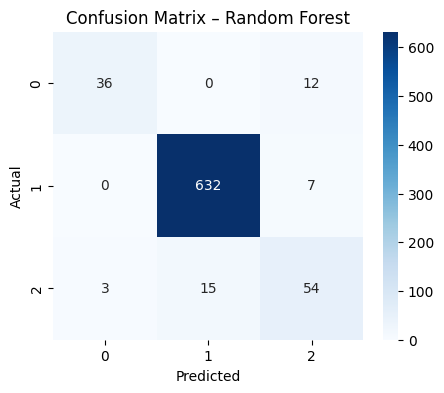

In [18]:
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
rf_prob = rf_model.predict_proba(X_test)


In [20]:

from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(
    y_test,
    rf_prob,
    multi_class="ovr",     # One-Vs-Rest
    average="weighted"
)

print("Random Forest ROC–AUC :", auc_score)


Random Forest ROC–AUC : 0.9958215505451339


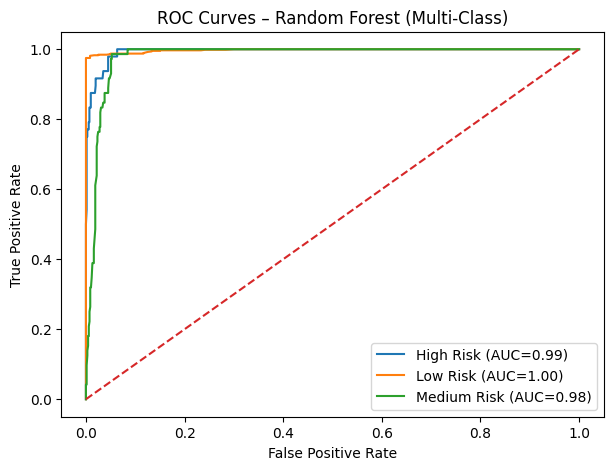

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels
y_test_bin = label_binarize(y_test, classes=[0,1,2])

plt.figure(figsize=(7,5))

for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], rf_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Random Forest (Multi-Class)")
plt.legend()
plt.show()


In [22]:

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="multi:softprob",   # ⭐ multi-class
    num_class=3,                  # Low / Medium / High
    eval_metric="mlogloss",
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [23]:
xgb_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [24]:
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nXGBoost Evaluation")
print("Accuracy :", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred, average="weighted"))
print("Recall   :", recall_score(y_test, xgb_pred, average="weighted"))
print("F1 Score :", f1_score(y_test, xgb_pred, average="weighted"))




XGBoost Evaluation
Accuracy : 0.9670619235836627
Precision: 0.9695670472844387
Recall   : 0.9670619235836627
F1 Score : 0.9672724146574778


In [26]:
from sklearn.metrics import roc_auc_score

xgb_auc = roc_auc_score(
    y_test,
    xgb_prob,
    multi_class="ovr",
    average="weighted"
)

print("ROC–AUC :", xgb_auc)


ROC–AUC : 0.9969103235071421


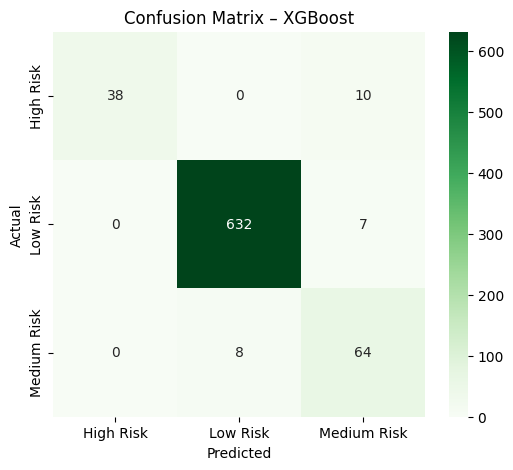

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_xgb = confusion_matrix(y_test, xgb_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost")
plt.show()



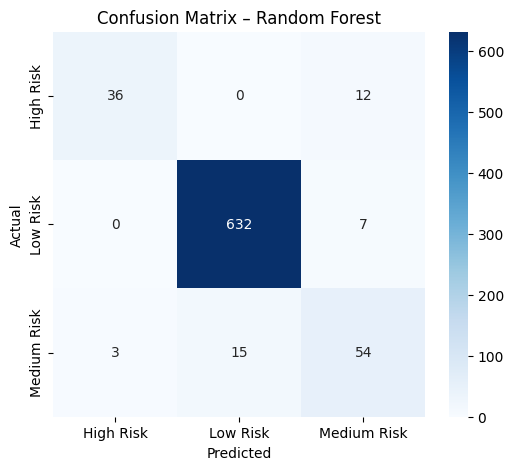

In [28]:
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()


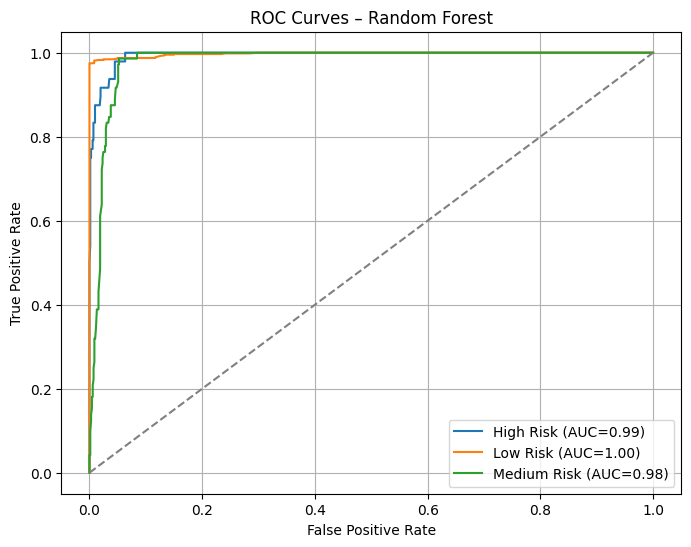

In [29]:
y_test_bin = label_binarize(y_test, classes=[0,1,2])

plt.figure(figsize=(8,6))

for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], rf_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Random Forest")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(
    y_test,
    rf_prob,
    multi_class="ovr",
    average="weighted"
)


In [31]:
lr_auc = roc_auc_score(y_test, lr_prob, multi_class="ovr", average="weighted")
dt_auc = roc_auc_score(y_test, dt_prob, multi_class="ovr", average="weighted")
rf_auc = roc_auc_score(y_test, rf_prob, multi_class="ovr", average="weighted")
xgb_auc = roc_auc_score(y_test, xgb_prob, multi_class="ovr", average="weighted")


In [32]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, dt_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    "F1 Score": [
        f1_score(y_test, lr_pred, average="weighted"),
        f1_score(y_test, dt_pred, average="weighted"),
        f1_score(y_test, rf_pred, average="weighted"),
        f1_score(y_test, xgb_pred, average="weighted")
    ],
    "ROC-AUC": [lr_auc, dt_auc, rf_auc, xgb_auc]
})

results


,Model,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,0.977602,0.977453,0.999206
1,Decision Tree,0.947299,0.949825,0.972968
2,Random Forest,0.951252,0.950488,0.995822
3,XGBoost,0.967062,0.967272,0.996910


In [33]:
import os
import joblib



In [34]:
# Create directories if not exist
os.makedirs("../outputs/models", exist_ok=True)


In [35]:
joblib.dump(xgb_model, "../outputs/models/xgboost_final.pkl")
joblib.dump(imputer, "../outputs/models/imputer.pkl")
joblib.dump(scaler, "../outputs/models/scaler.pkl")
joblib.dump(le, "../outputs/models/label_encoder.pkl")

print("✅ Final model and preprocessing files saved successfully")



✅ Final model and preprocessing files saved successfully


In [36]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted"
)

print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1 score:", cv_scores.mean())


Cross-validation F1 scores: [0.96451319 0.96767653 0.96217186 0.9737461  0.97348323]
Mean CV F1 score: 0.968318181748628


mental_wellbeing_score              0.486914
physical_activity_hours_per_week    0.110944
stress_level                        0.050461
diet_quality                        0.043118
sleep_hours_per_day                 0.036172
age                                 0.030268
water_intake_liters                 0.029541
weight_kg                           0.027829
height_cm                           0.026162
gender                              0.026130
dtype: float32


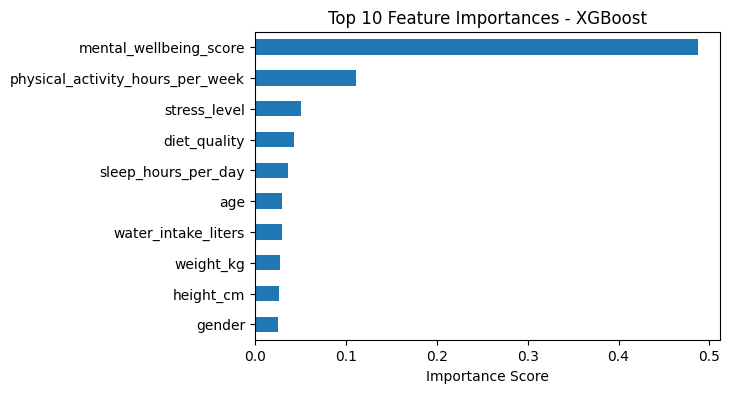

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(feature_importance.head(10))

# Optional plot (recommended)
feature_importance.head(10).plot(kind="barh", figsize=(6,4))
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


In [38]:
# Predict probabilities
probs = xgb_model.predict_proba(X_test)

# Assume class index 0 = High Risk
high_risk_prob = probs[:, 0]

# Custom business threshold
custom_threshold = 0.35

pred_custom = (high_risk_prob >= custom_threshold).astype(int)


In [39]:
from scipy.stats import ttest_rel
from sklearn.model_selection import cross_val_score

# Cross-validation scores
lr_cv = cross_val_score(
    lr_model, X_train_scaled, y_train,
    cv=5, scoring="f1_weighted"
)

xgb_cv = cross_val_score(
    xgb_model, X_train, y_train,
    cv=5, scoring="f1_weighted"
)

# Paired t-test
t_stat, p_value = ttest_rel(lr_cv, xgb_cv)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 5.354172054489104
P-value: 0.00586919754725012


In [40]:
from sklearn.metrics import f1_score

# Training performance
train_pred = xgb_model.predict(X_train)
train_f1 = f1_score(y_train, train_pred, average="weighted")

# Test performance
test_pred = xgb_model.predict(X_test)
test_f1 = f1_score(y_test, test_pred, average="weighted")

print("Train F1:", train_f1)
print("Test F1 :", test_f1)
print("Difference:", train_f1 - test_f1)


Train F1: 1.0
Test F1 : 0.9672724146574778
Difference: 0.03272758534252218


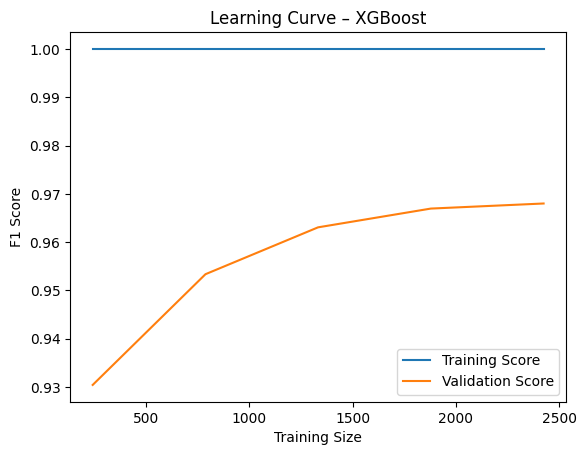

In [41]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    xgb_model,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted",
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, val_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve – XGBoost")
plt.legend()
plt.show()


In [42]:
final_summary = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "ROC-AUC"],
    "Value": [
        accuracy_score(y_test, xgb_model.predict(X_test)),
        f1_score(y_test, xgb_model.predict(X_test), average="weighted"),
        roc_auc_score(y_test, xgb_model.predict_proba(X_test),
                      multi_class="ovr", average="weighted")
    ]
})

final_summary



,Metric,Value
0,Accuracy,0.967062
1,F1 Score,0.967272
2,ROC-AUC,0.996910
